**6. (25%, coding assignment) See file NaiveBayse_MNIST_Problems.**

In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [ ]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
from sklearn.datasets import load_digits
mnist = load_digits()
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)



# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]


data shape:  (1797, 64)
label shape: (1797,)


### A. Create a 10x10 grid to visualize 10 examples of each digit.

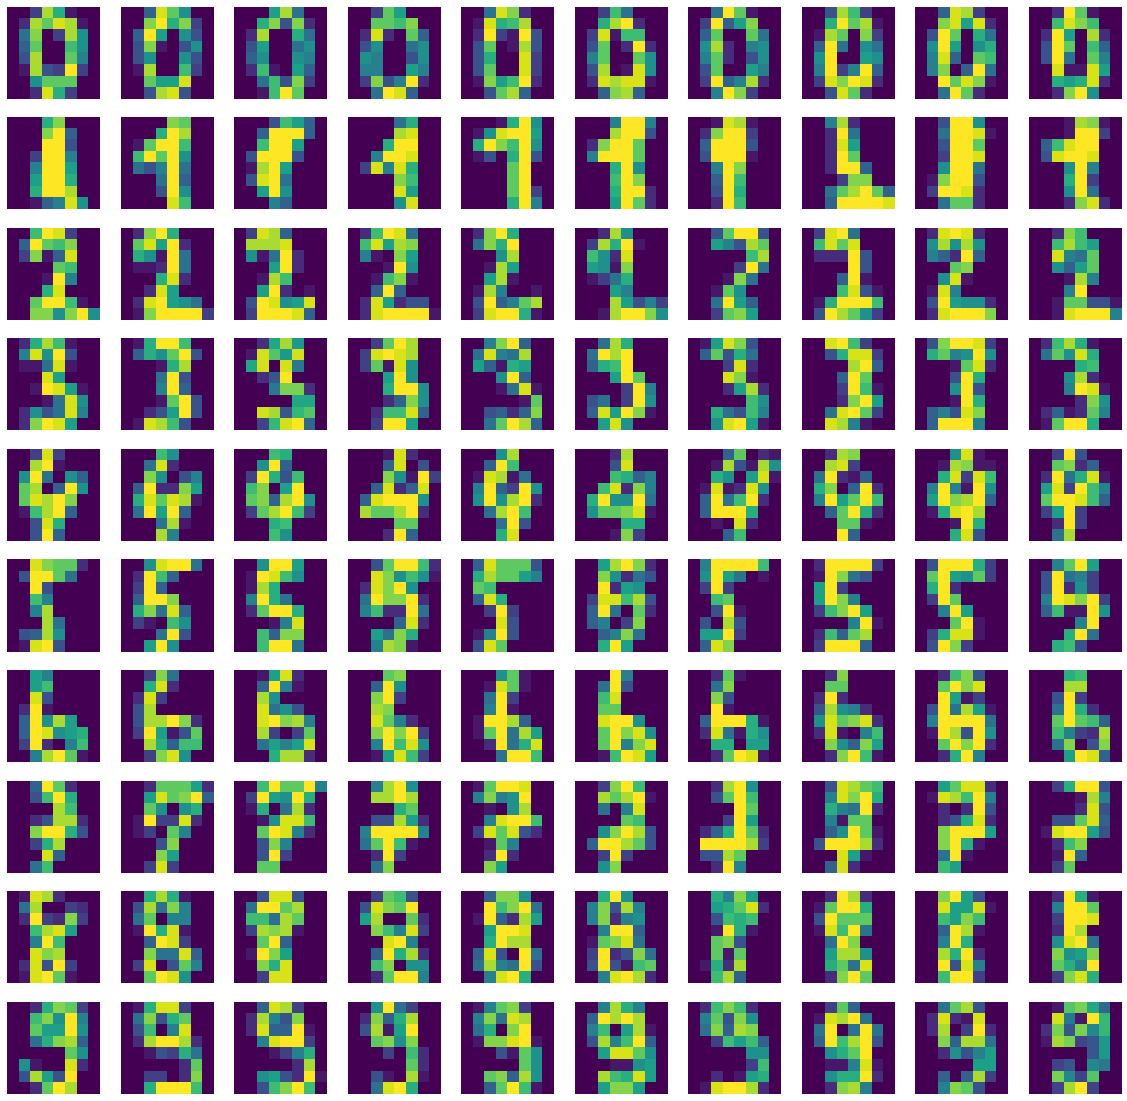

In [ ]:
# Collect 10 examples for each digit
digits = np.unique(mini_train_labels)

fig, axs = plt.subplots(len(digits), 10, figsize=(20,20))

for i, d in enumerate(digits):
    for j in range(10):
        axs[i, j].imshow(mini_train_data[mini_train_labels == d][j].reshape((8, 8)))
        axs[i, j].axis('off')

### B.  Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?
### Note, the answers may vary depending on what thresholds you set.

In [ ]:
import pandas as pd
from sklearn.preprocessing import binarize, MinMaxScaler

def convert(v, classes):
  cl = len(classes)
  for i in range(cl):
    if v <= ((1 + i) / cl):
      o = classes[i]
      break
  return o

def cont_to_class(data, cl=3):
  scaler = MinMaxScaler()
  scaler.fit(data)
  res = scaler.transform(data)
  res = pd.DataFrame(res)
  cols = res.columns
  classes = [i for i in range(cl)]
  for c in cols:
    res[c] = res[c].apply(lambda v: convert(v, classes))
  return res

dev_data_binarized = binarize(dev_data)
test_data_binarized = binarize(test_data)
bnb = BernoulliNB()
y_pred = bnb.fit(dev_data_binarized, dev_labels).predict(test_data_binarized)
print("Bernoulli accuracy : %f" % (accuracy_score(y_pred, test_labels)))

dev_data_3_classes = cont_to_class(dev_data)
test_data_3_classes = cont_to_class(test_data)
mnb = MultinomialNB()
y_pred = mnb.fit(dev_data_3_classes, dev_labels).predict(test_data_3_classes)
print("Multinomial accuracy : %f" % (accuracy_score(y_pred, test_labels)))

Bernoulli accuracy : 0.836576
Multinomial accuracy : 0.856031


The multi-class version improves the results. Although the improvment is not much, the 3 class variables conversion might train the model with not only the shape of the integer, but also the shadow around the integer. From the above grids, we can see that each example has the shape and the outline of the integer. The outline in this case might be the reason that gives the multinominal NB a slight edge over the binary model.

### C. Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Could you explain why?

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(dev_data, dev_labels).predict(test_data)
print("Gaussian accuracy : %f" % (accuracy_score(y_pred, test_labels)))

Gaussian accuracy : 0.704280


Typically, when using continuous numbers for NB, it requires the use of probability density function. In the above case, where the gaussian formula is used, might not be suitable for the distribution of the dataset because the weight that is given to each subsequent value in the training could potentially messed up the prediction.

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(train_data, train_labels).predict(test_data)
print("Gaussian accuracy : %f" % (accuracy_score(y_pred, test_labels)))

Gaussian accuracy : 0.821012


With a bigger training dataset, the performance of Gaussian NB classifer improves significantly, but it still underperform compared to Bernoulli with binary variables and Multinominal with 3 variables, where they both trained with a smaller portion of data. The conclusion we can make from these observation is that when encountering real number features, naive Bayes model is not the best option for machine learning.